[Blog to Refer](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/)

## Imports

In [54]:
# data manulplation
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# statstical testing
from scipy import stats

# train test split
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector

# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

# metrcs
from sklearn.metrics import f1_score

# general
import os
from typing import List
import warnings
warnings.filterwarnings('ignore')

## Read Data

In [2]:
DATA_DIR = r"Dataset/clean_data/Transformed_data"
DATA_DIR = "Dataset/clean_data/Transformed_data/train_iteratoin4.csv"
# df = pd.read_csv(os.path.join( DATA_DIR, "train_iteration4.csv"))
df = pd.read_csv(DATA_DIR)

In [3]:
df.shape

(891, 33)

In [4]:
df.head()

,Survived,Name_Words,Name_Length,Name_Init_labelencode,Name_Init_ordinalencode,Name_Init_Capt,Name_Init_Col,Name_Init_Countess,Name_Init_Don,Name_Init_Dr,...,Embraked_labelencoded,Embarked_ordinalencode,Embarked_C,Embarked_Q,Embarked_S,Pclass,SibSp,Parch,Age_MinMax,Fare_MinMax
0,0,4,23,12,0.0,0.0,0.0,0.0,0.0,0.0,...,2,0.0,0.0,0.0,1.0,3,1,0,0.271174,0.014151
1,1,7,51,13,2.0,0.0,0.0,0.0,0.0,0.0,...,0,1.0,1.0,0.0,0.0,1,1,0,0.472229,0.139136
2,1,3,22,9,1.0,0.0,0.0,0.0,0.0,0.0,...,2,0.0,0.0,0.0,1.0,3,0,0,0.321438,0.015469
3,1,7,44,13,2.0,0.0,0.0,0.0,0.0,0.0,...,2,0.0,0.0,0.0,1.0,1,1,0,0.434531,0.103644
4,0,4,24,12,0.0,0.0,0.0,0.0,0.0,0.0,...,2,0.0,0.0,0.0,1.0,3,0,0,0.434531,0.015713


In [5]:
df.columns

Index(['Survived', 'Name_Words', 'Name_Length', 'Name_Init_labelencode',
       'Name_Init_ordinalencode', 'Name_Init_Capt', 'Name_Init_Col',
       'Name_Init_Countess', 'Name_Init_Don', 'Name_Init_Dr',
       'Name_Init_Jonkheer', 'Name_Init_Lady', 'Name_Init_Major',
       'Name_Init_Master', 'Name_Init_Miss', 'Name_Init_Mlle', 'Name_Init_Mme',
       'Name_Init_Mr', 'Name_Init_Mrs', 'Name_Init_Ms', 'Name_Init_Rev',
       'Name_Init_Sir', 'Sex_labelencode', 'Embraked_labelencoded',
       'Embarked_ordinalencode', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Pclass', 'SibSp', 'Parch', 'Age_MinMax', 'Fare_MinMax'],
      dtype='object')

In [6]:
# df.info()

In [7]:
TARGET_COL = ["Survived"]
NUM_FATURES = ["Name_Words", "Name_Length",  'SibSp', 'Parch', 'Age_MinMax', 'Fare_MinMax']
CAT_FEATURES = ["Name_Init_labelencode", "Name_Init_ordinalencode",'Name_Init_Capt', 'Name_Init_Col',
       'Name_Init_Countess', 'Name_Init_Don', 'Name_Init_Dr',
       'Name_Init_Jonkheer', 'Name_Init_Lady', 'Name_Init_Major',
       'Name_Init_Master', 'Name_Init_Miss', 'Name_Init_Mlle', 'Name_Init_Mme',
       'Name_Init_Mr', 'Name_Init_Mrs', 'Name_Init_Ms', 'Name_Init_Rev',
       'Name_Init_Sir', 'Sex_labelencode', 'Embraked_labelencoded',
       'Embarked_ordinalencode', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Pclass',]

# Feature Selection

## Filter Methods

In [8]:
# Define custom colors and boundaries
colors = ['#0D47A1', '#1976D2', '#64B5F6', '#90CAF9',  # Blue shades for positive values
          '#FFEB3B', '#FFC107', '#FF9800', '#F57C00']  # Orange shades for negative values

In [9]:
def highlight_scores(value):
    # print(value)
    if value > 0:
        if value >= 0.75: # 0.76 to 1.0
            return f'background-color: {colors[0]}; color: green'
        elif value >= 0.50: # 0.51 to 0.75 
            return f'background-color: {colors[1]}; color: black'
        elif value >= 0.25: # 0.26 to 0.50
            return f'background-color: {colors[2]}; color: black'
        else: # 0.0 to 0.25  
            return f'background-color: {colors[3]}; color: red'
    else:
        if  value >=-0.25 : # 0.0 to -0.25 
            return f'background-color: {colors[4]}; color: red'
        elif value >= -0.50: # -0.26 to -0.50
            return f'background-color: {colors[5]}; color: black'
        elif value >= -0.75: # -0.51 to -0.75
            return f'background-color: {colors[6]}; color: black'
        else:  # -0.76 to -1
            return f'background-color: {colors[7]}; color: green'

#### Removing Less Correlated features with Target

```
Corr(feature_1 X Target)    = 0.39 # drop
Corr(feature_2 X Target)    = 0.65 

threshold = 0.4
```
**Solution:**

- To reduce garbage will drop `feature_1` 


In [10]:
# find features have high correlation with target variable
def correlation_with_target(corr_df:pd.DataFrame, target:str, threshold: float, add_neg=True):
    """ 
    this function is to filter the columns which has high correlation with target
    greater than mentioned threshold, also if we want to add highly correlated
    negative features, then we can get those by `add_neg=True` (default)
    """
    corr_columns = {}
    for column in corr_df.columns:
        if column not in [target]:
            corr_val = np.round(corr_df[column].iloc[0], 3)
            if corr_val > 0: # if positive
                if corr_val > threshold:
                    corr_columns.update({column: corr_val})
            elif add_neg == True:
                if corr_val < -threshold:
                    corr_columns.update({column: corr_val})
    return corr_columns

#### Removing Inter-Correlated features

**Case 1 :**

```
Corr(feature_1 X Target)    = 0.39 # drop
Corr(feature_2 X Target)    = 0.45 

Corr(feature_1 X feature_2) = 0.75 
```
**Solution:**

- To reduce inter-correlation will drop `feature_1` 
- and adding `feature_2` into list 

**Case 2 :**

```
Corr(feature_3 X Target)    = 0.55 

Corr(feature_2 X feature_3) = 0.85 
```
**Conflict:**

- `feature_2` already exists in list
- 1st we have to drop `feature_2`
- now we have to add `feature_3` in list


In [11]:
# eliminate features which has high inter correlation with features other than target
def inter_correlation_eleimination(corr_df:pd.DataFrame, target:str, max_inter_corr_thre:float):
    """ 
    this function is to filter the columns which has high correlation with other
    independent features, also it will take care of negatively correlated features
    and return list of features which has no inter correlation (aim is to get features
    which are independent to each other)

    Example:

    feature_1 -> target : corr_1 = 0.5
    feature_2 -> target : corr_2 = 0.8
    
    feature_1 <-> feature_2 : inter_corr = - 0.7

    max_inter_corr_thre = 0.5

    if abs(inter_corr) > max_inter_corr_thre :
        return max { abs(corr_1), abs(corr_2) }
    
    then will eliminate : feature_1
    """
    independent_columns = {}
    # skipping target
    columns = corr_df.columns.to_list()
        
    for feature_1 in columns:
        if feature_1 not in [target]:
            corr_val_feature_1 = np.round(corr_df[target].iloc[0], 3) # feature_1 -> target
            for index_f2, feature_2 in enumerate(columns):
                if feature_2 not in [feature_1, target]:
                    corr_val_feature_2 = np.round(corr_df[feature_2].iloc[0], 3) # feature_2 -> target
                    
                    inter_corr_f1_f2 = np.round(corr_df[feature_2].iloc[index_f2], 3) # row: feature_1, column: feature_2

                    # only less inter_correlated features than threshold
                    if np.abs(inter_corr_f1_f2) < max_inter_corr_thre:
                        if np.abs(corr_val_feature_1) > np.abs(corr_val_feature_2):
                            # drop feature_2 if it exisis in list
                            # if feature_2 in independent_columns.keys():
                            #     del independent_columns[feature_2]
                            # else:
                            independent_columns.update({feature_1: corr_val_feature_1})
                        else:
                            # drop feature_2 if it exisis in list
                            # if feature_1 in independent_columns.keys():
                            #     del independent_columns[feature_1]
                            # else:
                            independent_columns.update({feature_2: corr_val_feature_2})
    return independent_columns

#### Stats-Test Filtters :

In [12]:
# possible statstical method to filter all combination of feature and target
def statistical_filtering(df:pd.DataFrame, num_features:List[str], cat_features:List[str], target:List[str]):
    """
    this function will filter numerical and categorical variables
    based on statstical test score if there is a significance 
    """
    report_df = pd.DataFrame()
    filtered_num_col = []
    filtered_cat_cols = []

    # numrical features: int -> cat | float -> cat
    
    # check normality

    # parametric

    # non parametricsss

    # add to report

    # filter num columns

    # categorical features: binary -> cat | ordinal -> cat | nominal -> cat
    for column in cat_features:
        unique = df[column].nunique()
        if unique > 2:
            pass
            # parametric
            # non parametric
        else:
            pass 
            # parametric
            # non parametric

    # add to report

    # filter cat columns

    return filtered_num_col, filtered_cat_cols, report_df

### Correlation Coefficient :

In [13]:
df_corr_person = df.corr(method='pearson') # assumption : if data had linear relation : parametric
df_corr_kendall = df.corr(method='kendall') # two categorical variables
df_corr_spearman = df.corr(method='spearman') # assumption : if data had non linear relation : non-parametric


In [14]:
df_corr_person.style.applymap(highlight_scores, subset=df.columns)

,Survived,Name_Words,Name_Length,Name_Init_labelencode,Name_Init_ordinalencode,Name_Init_Capt,Name_Init_Col,Name_Init_Countess,Name_Init_Don,Name_Init_Dr,Name_Init_Jonkheer,Name_Init_Lady,Name_Init_Major,Name_Init_Master,Name_Init_Miss,Name_Init_Mlle,Name_Init_Mme,Name_Init_Mr,Name_Init_Mrs,Name_Init_Ms,Name_Init_Rev,Name_Init_Sir,Sex_labelencode,Embraked_labelencoded,Embarked_ordinalencode,Embarked_C,Embarked_Q,Embarked_S,Pclass,SibSp,Parch,Age_MinMax,Fare_MinMax
Survived,1.000000,0.276512,0.332350,-0.201345,0.294715,-0.026456,0.011329,0.042470,-0.026456,0.008185,-0.026456,0.042470,0.011329,0.085221,0.327093,0.060095,0.042470,-0.549199,0.339040,0.042470,-0.064988,0.042470,-0.543351,-0.167675,0.106811,0.168240,0.003650,-0.149683,-0.338481,-0.035322,0.081629,-0.064910,0.257307
Name_Words,0.276512,1.000000,0.922586,0.193669,0.295847,-0.001932,-0.023035,0.112842,-0.001932,-0.037775,-0.001932,0.112842,-0.002734,-0.007858,-0.124525,0.037868,-0.001932,-0.353938,0.637876,-0.030626,-0.016493,0.084148,-0.375778,0.031348,-0.117474,0.021336,-0.147658,0.074230,-0.221348,0.141757,0.215977,0.064964,0.152981
Name_Length,0.332350,0.922586,1.000000,0.099694,0.365015,0.003739,-0.010048,0.104917,-0.010715,-0.027074,0.014580,0.137438,0.023187,0.053399,-0.042814,0.035970,0.007353,-0.456480,0.638699,-0.007101,-0.008567,0.061555,-0.448759,0.022885,-0.107749,0.027481,-0.140941,0.064620,-0.220001,0.165019,0.252282,0.039702,0.155832
Name_Init_labelencode,-0.201345,0.193669,0.099694,1.000000,-0.405843,-0.201798,-0.260099,-0.165831,-0.147847,-0.344750,-0.111879,-0.093895,-0.107416,-0.374668,-0.603751,-0.031074,-0.003976,0.491325,0.385540,0.049975,0.166935,0.085943,0.256407,0.066462,-0.122448,-0.023314,-0.122203,0.097327,0.045541,-0.191786,-0.119721,0.272384,-0.086359
Name_Init_ordinalencode,0.294715,0.295847,0.365015,-0.405843,1.000000,0.192735,0.213150,0.171685,0.297986,0.176364,0.319036,0.255886,0.183364,0.293539,0.049636,0.153578,0.276936,-0.623161,0.293258,0.213786,0.214897,0.234836,-0.339311,-0.093935,0.050181,0.099480,-0.012511,-0.079275,-0.212640,0.155206,0.175888,0.000764,0.098668
Name_Init_Capt,-0.026456,-0.001932,0.003739,-0.201798,0.192735,1.000000,-0.001590,-0.001124,-0.001124,-0.002983,-0.001124,-0.001124,-0.001590,-0.007267,-0.016983,-0.001590,-0.001124,-0.039411,-0.013541,-0.001124,-0.002760,-0.001124,0.024728,0.019641,-0.019067,-0.016158,-0.010310,0.020643,-0.052496,0.014507,0.025731,0.104685,0.026184
Name_Init_Col,0.011329,-0.023035,-0.010048,-0.260099,0.213150,-0.001590,1.000000,-0.001590,-0.001590,-0.004221,-0.001590,-0.001590,-0.002250,-0.010283,-0.024031,-0.002250,-0.001590,-0.055767,-0.019160,-0.001590,-0.003905,-0.001590,0.034990,-0.032167,0.010348,0.037766,-0.014588,-0.023904,-0.074282,-0.022508,-0.022467,0.104389,-0.001126
Name_Init_Countess,0.042470,0.112842,0.104917,-0.165831,0.171685,-0.001124,-0.001590,1.000000,-0.001124,-0.002983,-0.001124,-0.001124,-0.001590,-0.007267,-0.016983,-0.001590,-0.001124,-0.039411,-0.013541,-0.001124,-0.002760,-0.001124,-0.045439,0.019641,-0.019067,-0.016158,-0.010310,0.020643,-0.052496,-0.015907,-0.015878,0.009373,0.036645
Name_Init_Don,-0.026456,-0.001932,-0.010715,-0.147847,0.297986,-0.001124,-0.001590,-0.001124,1.000000,-0.002983,-0.001124,-0.001124,-0.001590,-0.007267,-0.016983,-0.001590,-0.001124,-0.039411,-0.013541,-0.001124,-0.002760,-0.001124,0.024728,-0.065106,0.033694,0.069538,-0.010310,-0.054430,-0.052496,-0.015907,-0.015878,0.027405,-0.003026
Name_Init_Dr,0.008185,-0.037775,-0.027074,-0.344750,0.176364,-0.002983,-0.004221,-0.002983,-0.002983,1.000000,-0.002983,-0.002983,-0.004221,-0.019292,-0.045085,-0.004221,-0.002983,-0.104624,-0.035947,-0.002983,-0.007327,-0.002983,0.039034,-0.028208,0.029419,0.022104,0.017874,-0.030612,-0.108935,0.003910,-0.042150,0.072752,0.030395


In [15]:
## capture columns with high correlation with target and also inter corrlation
pearson_features = set(correlation_with_target(df_corr_person, "Survived", 0.3).keys())

In [16]:
pearson_features

{'Name_Init_Miss',
 'Name_Init_Mr',
 'Name_Init_Mrs',
 'Name_Length',
 'Pclass',
 'Sex_labelencode'}

In [17]:
df_corr_kendall.style.applymap(highlight_scores, subset=df.columns)

,Survived,Name_Words,Name_Length,Name_Init_labelencode,Name_Init_ordinalencode,Name_Init_Capt,Name_Init_Col,Name_Init_Countess,Name_Init_Don,Name_Init_Dr,Name_Init_Jonkheer,Name_Init_Lady,Name_Init_Major,Name_Init_Master,Name_Init_Miss,Name_Init_Mlle,Name_Init_Mme,Name_Init_Mr,Name_Init_Mrs,Name_Init_Ms,Name_Init_Rev,Name_Init_Sir,Sex_labelencode,Embraked_labelencoded,Embarked_ordinalencode,Embarked_C,Embarked_Q,Embarked_S,Pclass,SibSp,Parch,Age_MinMax,Fare_MinMax
Survived,1.000000,0.218077,0.254681,-0.081571,0.483828,-0.026456,0.011329,0.042470,-0.026456,0.008185,-0.026456,0.042470,0.011329,0.085221,0.327093,0.060095,0.042470,-0.549199,0.339040,0.042470,-0.064988,0.042470,-0.543351,-0.155747,0.132087,0.168240,0.003650,-0.149683,-0.323533,0.085915,0.133933,-0.031055,0.266229
Name_Words,0.218077,1.000000,0.772030,0.256211,0.311830,0.006992,-0.021896,0.056846,0.006992,-0.032559,0.006992,0.056846,0.009894,0.021367,-0.086387,0.011223,0.006992,-0.281975,0.483035,-0.037940,-0.006759,0.053803,-0.285649,0.104597,-0.132372,-0.029916,-0.154178,0.123232,-0.195132,0.253047,0.220443,0.022368,0.221703
Name_Length,0.254681,0.772030,1.000000,0.123827,0.376856,0.014450,-0.009416,0.047586,-0.006953,-0.013144,0.025911,0.048129,0.037856,0.082794,0.020996,0.014451,0.018524,-0.361098,0.417389,-0.001630,0.006271,0.041013,-0.331131,0.069712,-0.097410,-0.008044,-0.126905,0.086908,-0.171896,0.243909,0.221290,-0.010721,0.206440
Name_Init_labelencode,-0.081571,0.256211,0.123827,1.000000,-0.201030,-0.061143,-0.086226,-0.060730,-0.060593,-0.159398,-0.059494,-0.059356,-0.083698,-0.363913,-0.619920,-0.040148,-0.028167,0.260245,0.620941,0.060181,0.149009,0.061143,0.086121,0.063639,-0.095023,0.005422,-0.138661,0.082509,-0.058717,-0.010587,-0.115206,0.289514,-0.007265
Name_Init_ordinalencode,0.483828,0.311830,0.376856,-0.201030,1.000000,0.060318,0.084865,0.060181,0.061005,0.153927,0.061143,0.060730,0.084476,0.354138,0.337477,0.084087,0.060868,-0.901218,0.523246,0.060456,0.144622,0.060593,-0.694563,-0.083016,0.079331,0.070380,0.036184,-0.084426,-0.156041,0.307525,0.359764,-0.087882,0.275251
Name_Init_Capt,-0.026456,0.006992,0.014450,-0.061143,0.060318,1.000000,-0.001590,-0.001124,-0.001124,-0.002983,-0.001124,-0.001124,-0.001590,-0.007267,-0.016983,-0.001590,-0.001124,-0.039411,-0.013541,-0.001124,-0.002760,-0.001124,0.024728,0.019848,-0.019848,-0.016158,-0.010310,0.020643,-0.046561,0.041114,0.049335,0.048357,0.036608
Name_Init_Col,0.011329,-0.021896,-0.009416,-0.086226,0.084865,-0.001590,1.000000,-0.001590,-0.001590,-0.004221,-0.001590,-0.001590,-0.002250,-0.010283,-0.024031,-0.002250,-0.001590,-0.055767,-0.019160,-0.001590,-0.003905,-0.001590,0.034990,-0.027397,0.018570,0.037766,-0.014588,-0.023904,-0.065884,-0.030831,-0.025505,0.064611,0.031740
Name_Init_Countess,0.042470,0.056846,0.047586,-0.060730,0.060181,-0.001124,-0.001590,1.000000,-0.001124,-0.002983,-0.001124,-0.001124,-0.001590,-0.007267,-0.016983,-0.001590,-0.001124,-0.039411,-0.013541,-0.001124,-0.002760,-0.001124,-0.045439,0.019848,-0.019848,-0.016158,-0.010310,0.020643,-0.046561,-0.021789,-0.018025,0.020575,0.040842
Name_Init_Don,-0.026456,0.006992,-0.006953,-0.060593,0.061005,-0.001124,-0.001590,-0.001124,1.000000,-0.002983,-0.001124,-0.001124,-0.001590,-0.007267,-0.016983,-0.001590,-0.001124,-0.039411,-0.013541,-0.001124,-0.002760,-0.001124,0.024728,-0.058571,0.046095,0.069538,-0.010310,-0.054430,-0.046561,-0.021789,-0.018025,0.031798,0.019403
Name_Init_Dr,0.008185,-0.032559,-0.013144,-0.159398,0.153927,-0.002983,-0.004221,-0.002983,-0.002983,1.000000,-0.002983,-0.002983,-0.004221,-0.019292,-0.045085,-0.004221,-0.002983,-0.104624,-0.035947,-0.002983,-0.007327,-0.002983,0.039034,-0.029003,0.029863,0.022104,0.017874,-0.030612,-0.102678,0.003708,-0.047851,0.059440,0.052383


In [18]:
## capture columns with high correlation with target and also inter corrlation
kendall_features = set(correlation_with_target(df_corr_kendall, "Survived", 0.3))

In [19]:
kendall_features

{'Name_Init_Miss',
 'Name_Init_Mr',
 'Name_Init_Mrs',
 'Name_Init_ordinalencode',
 'Pclass',
 'Sex_labelencode'}

In [20]:
df_corr_spearman.style.applymap(highlight_scores, subset=df.columns)

,Survived,Name_Words,Name_Length,Name_Init_labelencode,Name_Init_ordinalencode,Name_Init_Capt,Name_Init_Col,Name_Init_Countess,Name_Init_Don,Name_Init_Dr,Name_Init_Jonkheer,Name_Init_Lady,Name_Init_Major,Name_Init_Master,Name_Init_Miss,Name_Init_Mlle,Name_Init_Mme,Name_Init_Mr,Name_Init_Mrs,Name_Init_Ms,Name_Init_Rev,Name_Init_Sir,Sex_labelencode,Embraked_labelencoded,Embarked_ordinalencode,Embarked_C,Embarked_Q,Embarked_S,Pclass,SibSp,Parch,Age_MinMax,Fare_MinMax
Survived,1.000000,0.234616,0.305809,-0.086869,0.515248,-0.026456,0.011329,0.042470,-0.026456,0.008185,-0.026456,0.042470,0.011329,0.085221,0.327093,0.060095,0.042470,-0.549199,0.339040,0.042470,-0.064988,0.042470,-0.543351,-0.160196,0.135861,0.168240,0.003650,-0.149683,-0.339668,0.088879,0.138266,-0.037004,0.323736
Name_Words,0.234616,1.000000,0.880472,0.297565,0.356879,0.007523,-0.023556,0.061157,0.007523,-0.035028,0.007523,0.061157,0.010645,0.022987,-0.092938,0.012074,0.007523,-0.303359,0.519667,-0.040817,-0.007272,0.057883,-0.307312,0.114058,-0.148167,-0.032185,-0.165870,0.132578,-0.220829,0.285157,0.244629,0.031629,0.289798
Name_Length,0.305809,0.880472,1.000000,0.177046,0.475457,0.017350,-0.011306,0.057139,-0.008349,-0.015782,0.031113,0.057791,0.045456,0.099416,0.025211,0.017352,0.022242,-0.433589,0.501181,-0.001957,0.007531,0.049246,-0.397607,0.086044,-0.120360,-0.009659,-0.152381,0.104356,-0.216458,0.306576,0.273374,-0.011747,0.298848
Name_Init_labelencode,-0.086869,0.297565,0.177046,1.000000,-0.161030,-0.065113,-0.091825,-0.064674,-0.064528,-0.169750,-0.063357,-0.063211,-0.089134,-0.387546,-0.660178,-0.042755,-0.029996,0.277145,0.661266,0.064089,0.158686,0.065113,0.091714,0.069137,-0.104657,0.005774,-0.147665,0.087868,-0.064992,-0.019445,-0.127648,0.352187,-0.011270
Name_Init_ordinalencode,0.515248,0.356879,0.475457,-0.161030,1.000000,0.064235,0.090376,0.064089,0.064967,0.163923,0.065113,0.064674,0.089962,0.377136,0.359393,0.089548,0.064821,-0.959744,0.557227,0.064382,0.154014,0.064528,-0.739669,-0.090005,0.087825,0.074950,0.038534,-0.089909,-0.174481,0.338730,0.397939,-0.106670,0.357841
Name_Init_Capt,-0.026456,0.007523,0.017350,-0.065113,0.064235,1.000000,-0.001590,-0.001124,-0.001124,-0.002983,-0.001124,-0.001124,-0.001590,-0.007267,-0.016983,-0.001590,-0.001124,-0.039411,-0.013541,-0.001124,-0.002760,-0.001124,0.024728,0.020415,-0.020415,-0.016158,-0.010310,0.020643,-0.048883,0.042532,0.050931,0.057622,0.044515
Name_Init_Col,0.011329,-0.023556,-0.011306,-0.091825,0.090376,-0.001590,1.000000,-0.001590,-0.001590,-0.004221,-0.001590,-0.001590,-0.002250,-0.010283,-0.024031,-0.002250,-0.001590,-0.055767,-0.019160,-0.001590,-0.003905,-0.001590,0.034990,-0.028180,0.019101,0.037766,-0.014588,-0.023904,-0.069170,-0.031895,-0.026330,0.076990,0.038596
Name_Init_Countess,0.042470,0.061157,0.057139,-0.064674,0.064089,-0.001124,-0.001590,1.000000,-0.001124,-0.002983,-0.001124,-0.001124,-0.001590,-0.007267,-0.016983,-0.001590,-0.001124,-0.039411,-0.013541,-0.001124,-0.002760,-0.001124,-0.045439,0.020415,-0.020415,-0.016158,-0.010310,0.020643,-0.048883,-0.022540,-0.018608,0.024517,0.049664
Name_Init_Don,-0.026456,0.007523,-0.008349,-0.064528,0.064967,-0.001124,-0.001590,-0.001124,1.000000,-0.002983,-0.001124,-0.001124,-0.001590,-0.007267,-0.016983,-0.001590,-0.001124,-0.039411,-0.013541,-0.001124,-0.002760,-0.001124,0.024728,-0.060245,0.047412,0.069538,-0.010310,-0.054430,-0.048883,-0.022540,-0.018608,0.037890,0.023594
Name_Init_Dr,0.008185,-0.035028,-0.015782,-0.169750,0.163923,-0.002983,-0.004221,-0.002983,-0.002983,1.000000,-0.002983,-0.002983,-0.004221,-0.019292,-0.045085,-0.004221,-0.002983,-0.104624,-0.035947,-0.002983,-0.007327,-0.002983,0.039034,-0.029831,0.030716,0.022104,0.017874,-0.030612,-0.107798,0.003836,-0.049399,0.070829,0.063698


In [21]:
## capture columns with high correlation with target and also inter corrlation
spearman_features = set(correlation_with_target(df_corr_spearman, "Survived", 0.3))

In [22]:
spearman_features

{'Fare_MinMax',
 'Name_Init_Miss',
 'Name_Init_Mr',
 'Name_Init_Mrs',
 'Name_Init_ordinalencode',
 'Name_Length',
 'Pclass',
 'Sex_labelencode'}

#### Union Features

In [23]:
corr_features = TARGET_COL+list(pearson_features .union(kendall_features).union(spearman_features))

In [24]:
corr_features

['Survived',
 'Name_Init_Miss',
 'Name_Init_Mr',
 'Pclass',
 'Name_Init_ordinalencode',
 'Name_Length',
 'Name_Init_Mrs',
 'Fare_MinMax',
 'Sex_labelencode']

#### Eliminating Intercorrelated Features

In [34]:
## inter correlation
df_corr_person = df[corr_features].corr(method='pearson') # assumption : if data had linear relation : parametric
df_corr_kendall = df[corr_features].corr(method='kendall') # two categorical variables
df_corr_spearman = df[corr_features].corr(method='spearman') # assumption : if data had non linear relation : non-parametric


In [35]:
t_list = np.arange(0, 1 ,0.1).tolist()

In [36]:
df_corr_person.style.applymap(highlight_scores, subset=df_corr_person.columns)

,Survived,Name_Init_Miss,Name_Init_Mr,Pclass,Name_Init_ordinalencode,Name_Length,Name_Init_Mrs,Fare_MinMax,Sex_labelencode
Survived,1.000000,0.327093,-0.549199,-0.338481,0.294715,0.332350,0.339040,0.257307,-0.543351
Name_Init_Miss,0.327093,1.000000,-0.595692,-0.000576,0.049636,-0.042814,-0.204670,0.118271,-0.686808
Name_Init_Mr,-0.549199,-0.595692,1.000000,0.142698,-0.623161,-0.456480,-0.474952,-0.183766,0.867334
Pclass,-0.338481,-0.000576,0.142698,1.000000,-0.212640,-0.220001,-0.149209,-0.549500,0.131900
Name_Init_ordinalencode,0.294715,0.049636,-0.623161,-0.212640,1.000000,0.365015,0.293258,0.098668,-0.339311
Name_Length,0.332350,-0.042814,-0.456480,-0.220001,0.365015,1.000000,0.638699,0.155832,-0.448759
Name_Init_Mrs,0.339040,-0.204670,-0.474952,-0.149209,0.293258,0.638699,1.000000,0.105203,-0.547600
Fare_MinMax,0.257307,0.118271,-0.183766,-0.549500,0.098668,0.155832,0.105203,1.000000,-0.182333
Sex_labelencode,-0.543351,-0.686808,0.867334,0.131900,-0.339311,-0.448759,-0.547600,-0.182333,1.000000


In [27]:
inter_correlation_eleimination(df_corr_person, "Survived", 0.3)

{}

In [37]:
for i in t_list:
    l = inter_correlation_eleimination(df_corr_person, "Survived", i)
    print(l)

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


In [38]:
df_corr_kendall.style.applymap(highlight_scores, subset=df_corr_kendall.columns)

,Survived,Name_Init_Miss,Name_Init_Mr,Pclass,Name_Init_ordinalencode,Name_Length,Name_Init_Mrs,Fare_MinMax,Sex_labelencode
Survived,1.000000,0.327093,-0.549199,-0.323533,0.483828,0.254681,0.339040,0.266229,-0.543351
Name_Init_Miss,0.327093,1.000000,-0.595692,0.002291,0.337477,0.020996,-0.204670,0.062221,-0.686808
Name_Init_Mr,-0.549199,-0.595692,1.000000,0.142033,-0.901218,-0.361098,-0.474952,-0.272283,0.867334
Pclass,-0.323533,0.002291,0.142033,1.000000,-0.156041,-0.171896,-0.151793,-0.573531,0.129325
Name_Init_ordinalencode,0.483828,0.337477,-0.901218,-0.156041,1.000000,0.376856,0.523246,0.275251,-0.694563
Name_Length,0.254681,0.020996,-0.361098,-0.171896,0.376856,1.000000,0.417389,0.206440,-0.331131
Name_Init_Mrs,0.339040,-0.204670,-0.474952,-0.151793,0.523246,0.417389,1.000000,0.204146,-0.547600
Fare_MinMax,0.266229,0.062221,-0.272283,-0.573531,0.275251,0.206440,0.204146,1.000000,-0.213480
Sex_labelencode,-0.543351,-0.686808,0.867334,0.129325,-0.694563,-0.331131,-0.547600,-0.213480,1.000000


In [39]:
inter_correlation_eleimination(df_corr_kendall, "Survived", 0.2)

{}

In [40]:
for i in t_list:
    l = inter_correlation_eleimination(df_corr_kendall, "Survived", i)
    print(l)

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


In [30]:
df_corr_spearman.style.applymap(highlight_scores, subset=df_corr_spearman.columns)

,Survived,Name_Init_Miss,Name_Init_Mr,Pclass,Name_Init_ordinalencode,Name_Length,Name_Init_Mrs,Fare_MinMax,Sex_labelencode
Survived,1.000000,0.327093,-0.549199,-0.339668,0.515248,0.305809,0.339040,0.323736,-0.543351
Name_Init_Miss,0.327093,1.000000,-0.595692,0.002406,0.359393,0.025211,-0.204670,0.075661,-0.686808
Name_Init_Mr,-0.549199,-0.595692,1.000000,0.149116,-0.959744,-0.433589,-0.474952,-0.331099,0.867334
Pclass,-0.339668,0.002406,0.149116,1.000000,-0.174481,-0.216458,-0.159363,-0.688032,0.135775
Name_Init_ordinalencode,0.515248,0.359393,-0.959744,-0.174481,1.000000,0.475457,0.557227,0.357841,-0.739669
Name_Length,0.305809,0.025211,-0.433589,-0.216458,0.475457,1.000000,0.501181,0.298848,-0.397607
Name_Init_Mrs,0.339040,-0.204670,-0.474952,-0.159363,0.557227,0.501181,1.000000,0.248243,-0.547600
Fare_MinMax,0.323736,0.075661,-0.331099,-0.688032,0.357841,0.298848,0.248243,1.000000,-0.259593
Sex_labelencode,-0.543351,-0.686808,0.867334,0.135775,-0.739669,-0.397607,-0.547600,-0.259593,1.000000


In [41]:
for i in t_list:
    l = inter_correlation_eleimination(df_corr_spearman, "Survived", i)
    print(l)

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


### Statistical Tests : 
Select features based on statistical significance

## Wrapper Methods

[Blog to Refer](https://machinelearningmastery.com/growing-and-pruning-ensembles-in-python/)

In [42]:
# linear model
from sklearn.linear_model import LogisticRegression
# Byes model
from sklearn.naive_bayes import GaussianNB
# support vector machine
from sklearn.svm import SVC
# distance based model
from sklearn.neighbors import KNeighborsClassifier
# tree based
from sklearn.tree import DecisionTreeClassifier
# bagging special case
from sklearn.ensemble import RandomForestClassifier
# ensemble
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt

In [109]:
class Wrapper_Methods:

    def __init__(self, df:pd.DataFrame, features:List[str], target:List[str], scoring:str, cv:int, seed:int, shuffle:bool):
        self.df = df
        self.features = features
        self.target = target
        self.scoring = scoring
        self.cv = cv
        self.seed = seed
        self.shuffle = shuffle
        self.X, self.y = self.load_data()
        self.model_tags = ["LR", "NB", "SVM", "KNN", "DT", "RF", "GB", "AB", "ETC", "XGB", "XGRFB", 
                        #    "LGB", 
                           "CB"]

    def load_data(self):
        X = self.df[self.features].values
        y = self.df[self.target].iloc[:,0].values
        return X, y
    
    def get_model(self, model_tag):
        
        if model_tag == "LR":
            return {"LR": ("Logistic Regression", LogisticRegression(max_iter=1000))}
        
        if model_tag == "NB":        
            return {"NB": ("Naive Bayes", GaussianNB())}

        if model_tag == "SVM":        
            return {"SVM": ("Support Vector", SVC())}

        if model_tag == "KNN":         
            return {"KNN": ("K-Neighbors", KNeighborsClassifier(n_neighbors=2))}

        if model_tag == "DT":        
            return {"DT": ("Decision Tree", DecisionTreeClassifier())}

        if model_tag == "RF":        
            return {"RF": ("Random Forest", RandomForestClassifier())}

        if model_tag == "GB":        
            return {"GB": ("Gradient Boosting", GradientBoostingClassifier())}

        if model_tag == "AB":        
            return {"AB": ("Ada Boosting", AdaBoostClassifier())}

        if model_tag == "ETC":        
            return {"ETC": ("Extra Tres Boosting", ExtraTreesClassifier())}

        if model_tag == "XGB":        
            return {"XGB": ("Extra Gradient Boosting", XGBClassifier())}

        if model_tag == "XGRFB":        
            return {"XGRFB": ("Extra Random Forest Boosting", XGBRFClassifier())}

        if model_tag == "LGB":        
            return {"LGB": ("Light Boosting",LGBMClassifier(learning_rate=0.01, n_estimators=1000))}

        if model_tag == "CB":        
            return {"CB": ("Cat Boosting", CatBoostClassifier(verbose=0))}


    def evaluate_model(self, model, n_features:List[int]):
        # define the model evaluation procedure
        cv = StratifiedKFold(n_splits=self.cv, random_state=self.seed, shuffle=self.shuffle)
        # evaluate the model: n-jobs=-1 [uses all cores]
        scores = cross_val_score(model, self.X[:,n_features], self.y, scoring=self.scoring, cv=cv, n_jobs=-1)

        return scores
    
    def get_custome_scores(self, scores: List[float]):
        mean_score = np.mean(scores)
        std_score = np.std(scores)

        return mean_score, std_score
    
    def box_plot(self, names, results):
        """ 
        plots box plot for each feature combination
        """
        # plot model performance for comparison
        plt.boxplot(results, labels=names, showmeans=True)
        plt.xlabel("Models")
        plt.ylabel(f"Score: {self.scoring}")
        plt.title(f"Performance of Models")
        plt.show()

    def forward_feature_selection(self, model_tags:List[str], print_status:bool):
        
        # run model evaluation for all sub set of features
        model_report = dict()
        features_list = []
        mean_scores = []
        std_scores = []
        model_names = []
        all_scores = []

        # testing all features
        for model_tag in model_tags:

            # get model 
            model_name, model = self.get_model(model_tag)[model_tag]

            # model name
            if print_status:
                print('='*15,model_name,'='*15)

            # forward features selection
            selection_obj = SequentialFeatureSelector(
                estimator=model,             # try on this model
                n_features_to_select="auto", # select automatically,
                tol = None,                  # score threshould
                direction="forward",         # direction of feature selection
                scoring=self.scoring,        # evaluation metric
                cv=self.cv,                  # cross validation method
                n_jobs=-1,                   # use all cores
            )
            selection_obj.fit(self.X, self.y)

            # evaluating for score on selected features
            s = self.evaluate_model(model, selection_obj.get_support(indices=True))

            # collecting all scores
            all_scores.append(s)
            # mean scores
            mean, std = self.get_custome_scores(s)
            
            selected_features = selection_obj.get_feature_names_out(self.features)
            # print those scores
            if print_status:
                # print('='*15,model_name,'='*15)
                msg = f"{len(selected_features)} : Mean: {mean} Std: {std}\n"
                print(msg)
            
            features_list.append(selected_features)
            mean_scores.append(mean)
            std_scores.append(std)
            model_names.append(model_name)
            

        # collecting all scores
        model_report["model_name"] = model_names
        model_report[f"mean_{self.scoring}"] = mean_scores
        model_report[f"std_{self.scoring}"] = std_scores
        model_report["selected_features"] = features_list

        # plotting results
        self.box_plot(model_tags, all_scores)

        return model_report

    def backward_feature_elimination(self, model_tags:List[str], print_status:bool):
        # run model evaluation for all sub set of features
        pass

In [110]:
# parameters
DATA = df.copy()
FEATURES = [i for i in df.columns if i not in TARGET_COL]
SCORING = "f1"
CV = 3
SEED = 0
SHUFFLE = True

In [111]:
wrapper_obj = Wrapper_Methods(
    DATA,
    FEATURES,
    TARGET_COL,
    SCORING,
    CV,
    SEED,
    SHUFFLE
)

### Forward Selection: 
Add one feature at a time based on model performance.

=============== Logistic Regression ===============
16 : Mean: 0.7621111229806882 Std: 0.036292822587161364

=============== Naive Bayes ===============


/Users/rahulshelke/Documents/Data Science/EDA/ineuron/lib/python3.8/site-packages/sklearn/naive_bayes.py:510: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/Users/rahulshelke/Documents/Data Science/EDA/ineuron/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: RuntimeWarning: divide by zero encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/Users/rahulshelke/Documents/Data Science/EDA/ineuron/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: RuntimeWarning: invalid value encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/Users/rahulshelke/Documents/Data Science/EDA/ineuron/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: RuntimeWarning: invalid value encountered in subtract
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/Users/rahulshelke/Documents/Data Science/EDA/ineuron/l

16 : Mean: 0.6282396347525239 Std: 0.14070560895849865

=============== Support Vector ===============
16 : Mean: 0.7583218579919047 Std: 0.025649125001217417

=============== K-Neighbors ===============
16 : Mean: 0.6632750756966003 Std: 0.024265619703356972

=============== Decision Tree ===============
16 : Mean: 0.7489059779992262 Std: 0.04014160072256907

=============== Random Forest ===============
16 : Mean: 0.7534926649179053 Std: 0.03958165893989073

=============== Gradient Boosting ===============
16 : Mean: 0.7498868633196315 Std: 0.03861288183707681

=============== Ada Boosting ===============
16 : Mean: 0.7372152834674178 Std: 0.036785459330387286

=============== Extra Tres Boosting ===============
16 : Mean: 0.7534926649179053 Std: 0.03958165893989073

=============== Extra Gradient Boosting ===============
16 : Mean: 0.7504061813659337 Std: 0.04221183236317206

=============== Extra Random Forest Boosting ===============
16 : Mean: 0.7497999853007569 Std: 0.013810600

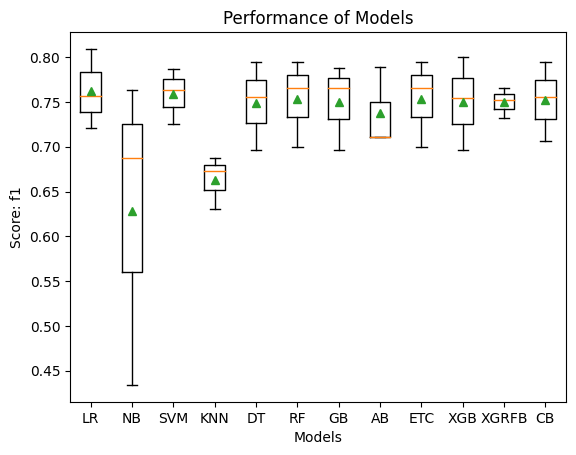

In [112]:
model_report = wrapper_obj.forward_feature_selection(wrapper_obj.model_tags, True)

In [114]:
pd.DataFrame(model_report).sort_values(by="mean_f1", ascending=False)

,model_name,mean_f1,std_f1,selected_features
0,Logistic Regression,0.762111,0.036293,"[Name_Init_Capt, Name_Init_Col, Name_Init_Coun..."
2,Support Vector,0.758322,0.025649,"[Name_Init_Capt, Name_Init_Col, Name_Init_Coun..."
5,Random Forest,0.753493,0.039582,"[Name_Init_Capt, Name_Init_Col, Name_Init_Coun..."
8,Extra Tres Boosting,0.753493,0.039582,"[Name_Init_Capt, Name_Init_Col, Name_Init_Coun..."
11,Cat Boosting,0.751923,0.036268,"[Name_Init_Capt, Name_Init_Col, Name_Init_Coun..."
9,Extra Gradient Boosting,0.750406,0.042212,"[Name_Init_labelencode, Name_Init_Capt, Name_I..."
6,Gradient Boosting,0.749887,0.038613,"[Name_Words, Name_Length, Name_Init_Capt, Name..."
10,Extra Random Forest Boosting,0.749800,0.013811,"[Name_Words, Name_Init_ordinalencode, Name_Ini..."
4,Decision Tree,0.748906,0.040142,"[Name_Init_Capt, Name_Init_Col, Name_Init_Coun..."
7,Ada Boosting,0.737215,0.036785,"[Name_Init_Capt, Name_Init_Countess, Name_Init..."


In [97]:
len(FEATURES)

32

In [100]:
lr = LogisticRegression(max_iter=1000)

sfs = SequentialFeatureSelector(lr, 
                                direction="forward", 
                                scoring="f1", 
                                n_jobs=-1, 
                                cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0))

In [89]:
sfs.fit(df[FEATURES], y)

SequentialFeatureSelector(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                          estimator=LogisticRegression(max_iter=1000),
                          n_jobs=-1, scoring='f1')

In [90]:
sfs.get_feature_names_out(input_features=FEATURES)

array(['Name_Init_labelencode', 'Name_Init_Capt', 'Name_Init_Col',
       'Name_Init_Countess', 'Name_Init_Don', 'Name_Init_Dr',
       'Name_Init_Jonkheer', 'Name_Init_Lady', 'Name_Init_Major',
       'Name_Init_Miss', 'Name_Init_Mr', 'Name_Init_Rev', 'Embarked_Q',
       'SibSp', 'Parch', 'Fare_MinMax'], dtype=object)

In [91]:
lr.fit(df[sfs.get_feature_names_out(input_features=FEATURES)], df[TARGET_COL])

LogisticRegression(max_iter=1000)

In [92]:
lr.score(df[sfs.get_feature_names_out(input_features=FEATURES)], df[TARGET_COL])

0.8294051627384961

In [93]:
y = df[TARGET_COL].iloc[:,0].values

In [94]:
s = cross_val_score(estimator=lr, 
                    X=df[sfs.get_feature_names_out(input_features=FEATURES)], 
                    y=y,
                    scoring="f1",
                    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
                    n_jobs=-1)

In [95]:
np.mean(s)

0.7681793856622232

In [96]:
sfs.get_support(indices=True)

array([ 2,  4,  5,  6,  7,  8,  9, 10, 11, 13, 16, 19, 25, 28, 29, 31])

### Backward Elimination: 
Start with all features and eliminate one at a time based on model performance.

## Embedded Methods

### Lasso Regression (L1 regularization): 
Penalize coefficients to zero, effectively performing feature selection.

### Decision Trees/Random Forests: 
Feature importance from ensemble methods.

## Dimensionality Reduction